---
## Technical Report Notebook 3
---
### Hail Modelling and Algorithm Investigation

In [20]:
# Import modelling libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.decomposition import PCA

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [22]:
# Reading in data 

hail_tweet_text = pd.read_csv("./hail_tweet_text.csv")
hail_tweet_text.drop('Unnamed: 0',axis=1,inplace=True)

### Create Hail Class

In [23]:
# Create hail class for classification analysis

hail_tweet_text['hail_class'] = 0

hail_tweet_text.ix[hail_tweet_text['hail'] >= 1, 'hail_class'] = 1
hail_tweet_text.ix[hail_tweet_text['hailstorm'] >= 1, 'hail_class'] = 1

hail_tweet_text_bris = hail_tweet_text[hail_tweet_text['Cat_ID'] == 144]
hail_tweet_text_syd = hail_tweet_text[hail_tweet_text['Cat_ID'] == 154]

In [24]:
# Create subsets of data for train/testing

In [25]:
htt_total = hail_tweet_text.ix[:,26:]
print (htt_total.shape)
htt_bris = hail_tweet_text_bris.ix[:,26:]
print (htt_bris.shape)
htt_syd = hail_tweet_text_syd.ix[:,26:]
print (htt_syd.shape)

y_total = htt_total.hail_class
y_bris = htt_bris.hail_class
y_syd = htt_syd.hail_class

(127989, 1002)
(46529, 1002)
(81460, 1002)


In [26]:
htt_total.drop(htt_total[['sydney','sydneystorm','brisbane','brisbanestorm','hail','hailstorm','hail_class']], axis=1, inplace=True)
htt_bris.drop(htt_bris[['sydney','sydneystorm','brisbane','brisbanestorm','hail','hailstorm','hail_class']], axis=1, inplace=True)
htt_syd.drop(htt_syd[['sydney','sydneystorm','brisbane','brisbanestorm','hail','hailstorm','hail_class']], axis=1, inplace=True)

In [27]:
ss = StandardScaler()

Xs_htt_total = ss.fit_transform(htt_total)
Xs_htt_bris = ss.fit_transform(htt_bris)
Xs_htt_syd = ss.fit_transform(htt_syd)

## Principle Component Analysis

In [28]:
# PCA On Full Dataset Set

pca = PCA()
pca.fit(Xs_htt_total)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [29]:
pca.explained_variance_ratio_.max()

0.011864892485503162

In [30]:
htt_pcs = pca.transform(Xs_htt_total)
htt_pcs = pd.DataFrame(htt_pcs, 
                       columns=['PC'+str(i+1) for i in range(len(htt_total.columns))],
                       index=htt_total.index)

In [31]:
htt_pcs.index.values

array([     0,      1,      2, ..., 127986, 127987, 127988])

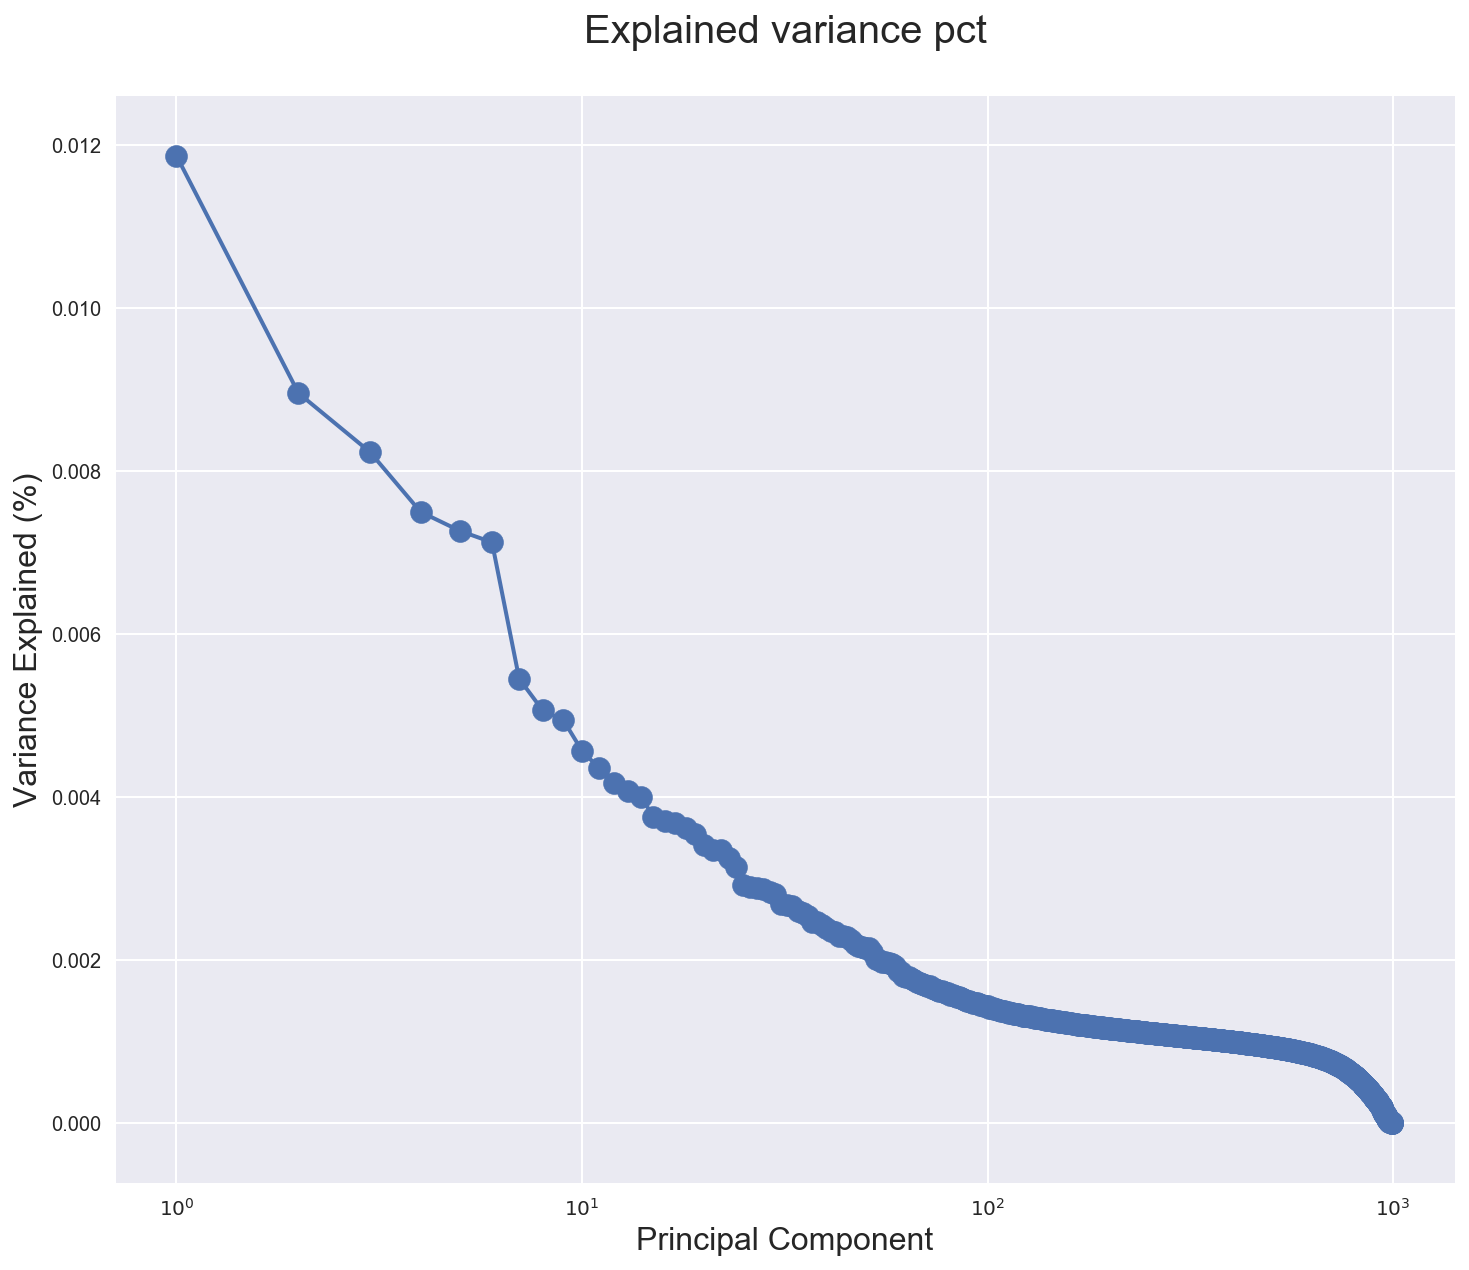

In [32]:
exp_var = pca.explained_variance_ratio_

fig, ax = plt.subplots(figsize=(12,10))
ax.plot(range(1, len(exp_var)+1), exp_var, lw=2)
ax.scatter(range(1, len(exp_var)+1), exp_var, s=120)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Variance Explained (%)', fontsize=16)
plt.xscale('log')
plt.show()

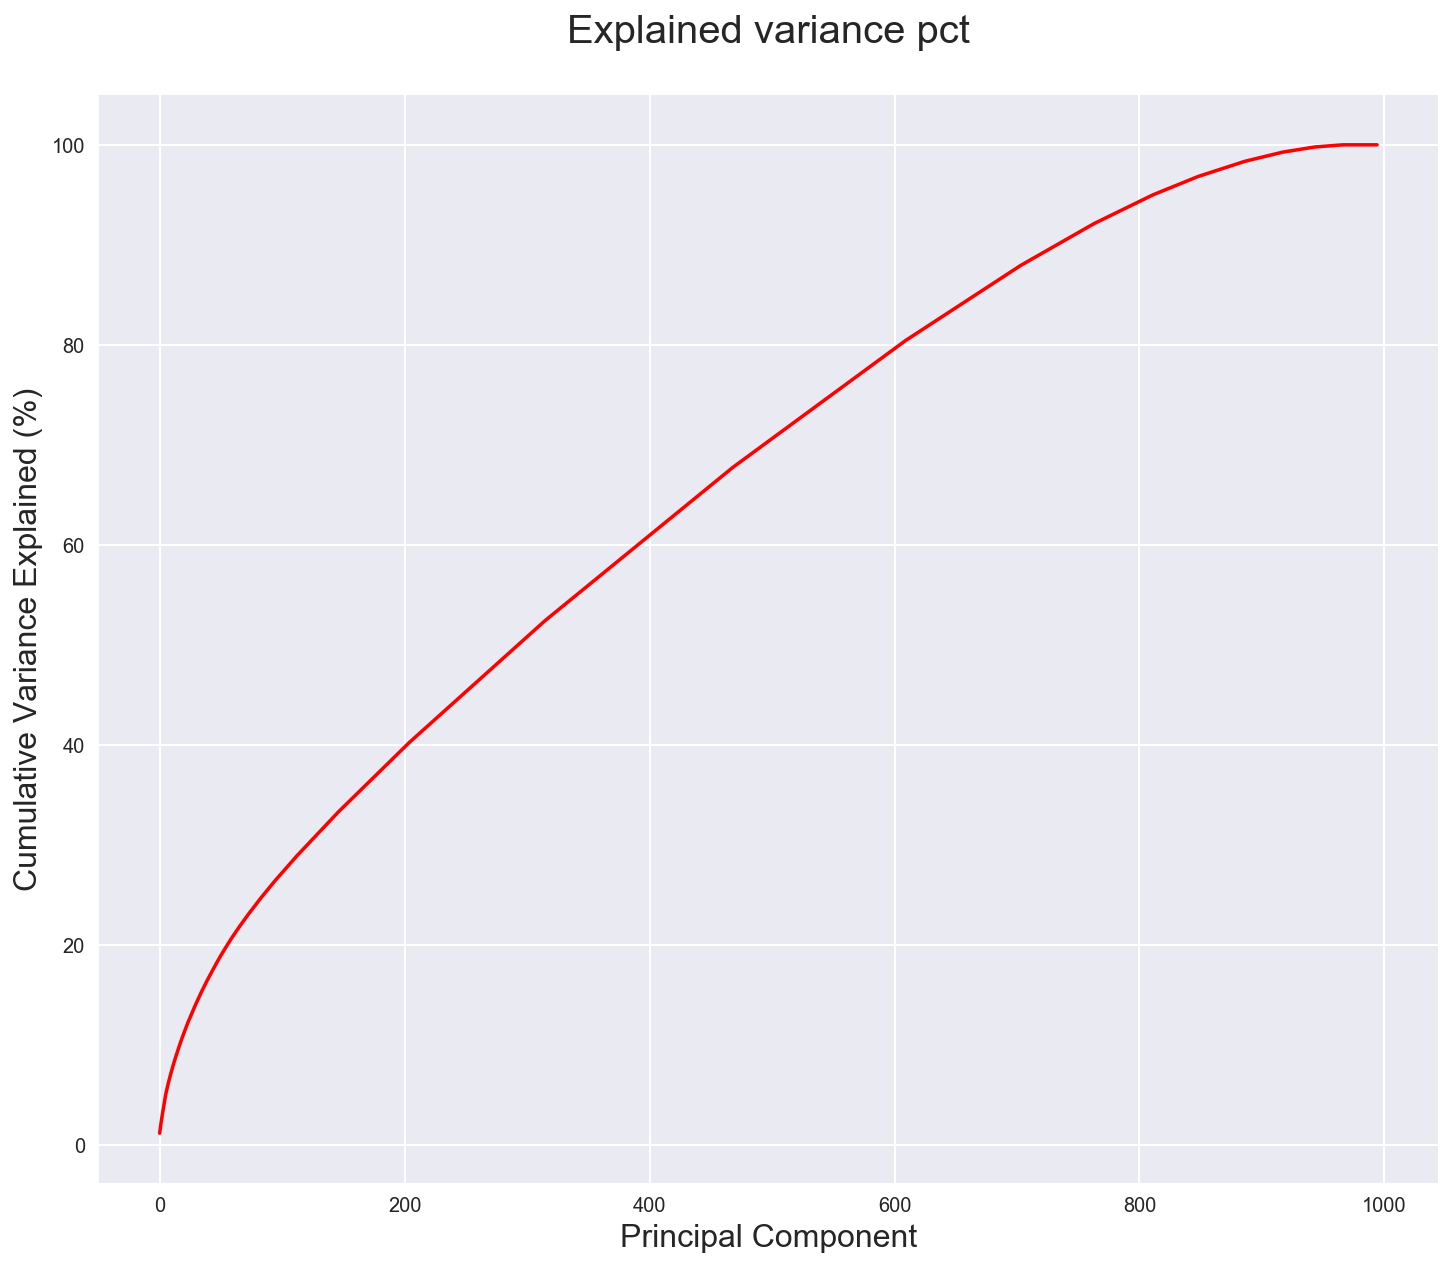

In [33]:
fig, ax = plt.subplots(figsize=(12,10))
var1=np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)
ax.set_title('Explained variance pct\n', fontsize=20)
ax.set_xlabel('Principal Component', fontsize=16)
ax.set_ylabel('Cumulative Variance Explained (%)', fontsize=16)
plt.plot(var1,color='red')

In [34]:
components = pd.DataFrame(pca.components_,
                 columns=['PC'+str(i+1) for i in range(len(htt_total.columns))],
                 index=htt_total.columns)
print (components['PC1'].nlargest(10))
print ("-----------")
print (components['PC2'].nlargest(10))
print ("-----------")
print (components['PC3'].nlargest(10))
print ("-----------")
print (components['PC4'].nlargest(10))
print ("-----------")
print (components['PC5'].nlargest(10))
print ("-----------")
print (components['PC6'].nlargest(10))

wolf        0.806483
actually    0.351023
warnings    0.194130
bc          0.081956
warning     0.060724
tracking    0.033305
steal       0.030616
spring      0.023535
big         0.023450
starts      0.022062
Name: PC1, dtype: float64
-----------
black       0.184392
birthday    0.104094
soar        0.102554
solar       0.097632
street      0.090399
strike      0.085942
online      0.080470
near        0.075847
people      0.074541
poor        0.073281
Name: PC2, dtype: float64
-----------
perxitaa    0.109993
ninja       0.102606
pacers      0.102115
park        0.100281
rainbow     0.098990
damaged     0.095521
pictures    0.095394
die         0.093282
mother      0.092254
nov         0.091262
Name: PC3, dtype: float64
-----------
beta          0.271425
struggling    0.139754
borno         0.136827
straight      0.136193
star          0.125487
book          0.118656
southern      0.115534
snarls        0.114655
brewing       0.105982
somerset      0.103702
Name: PC4, dtype: float64


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


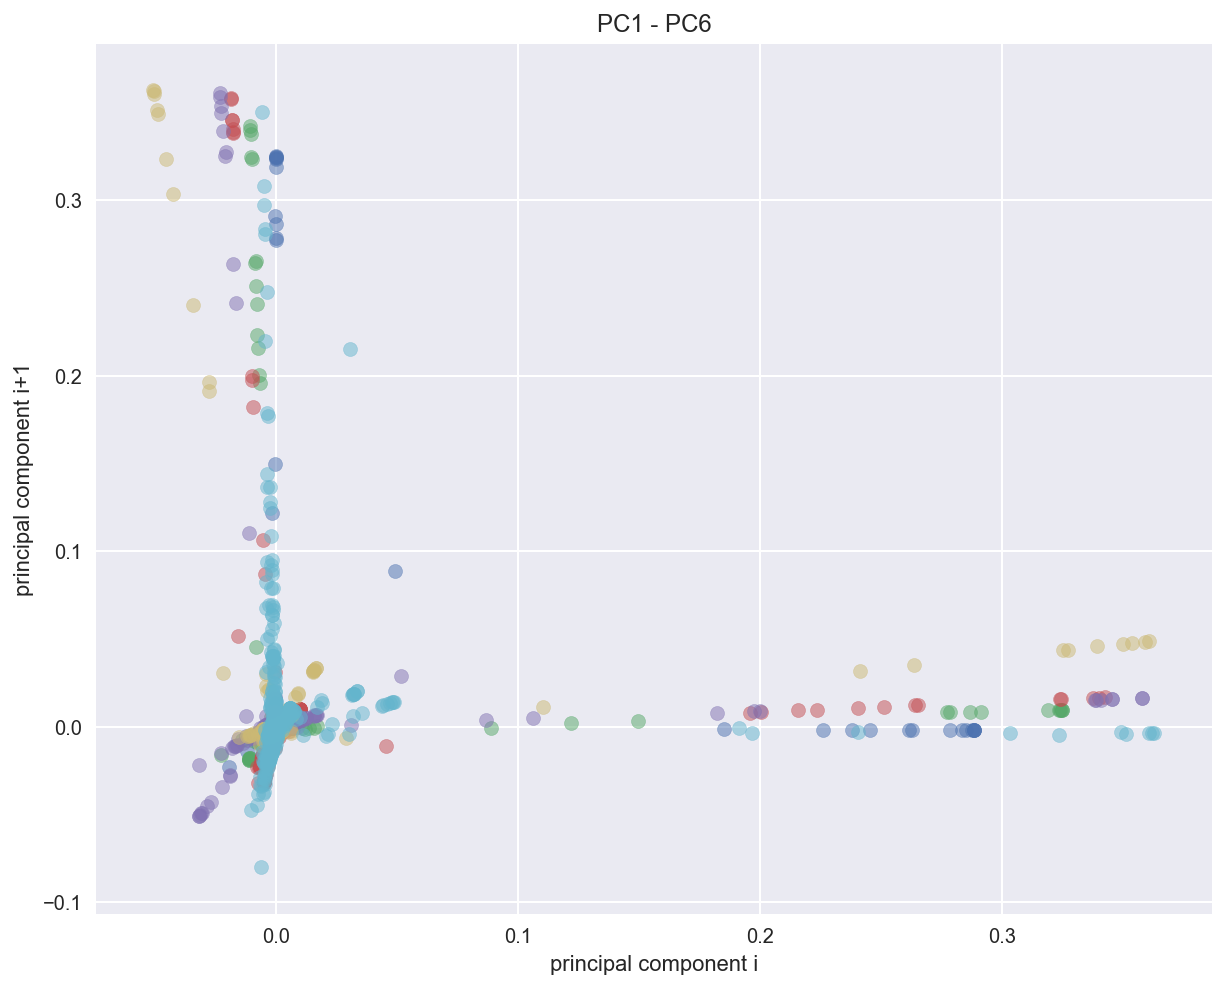

In [35]:
fig, ax = plt.subplots(figsize=(10,8))
ax.scatter(pca.components_[0], pca.components_[1], alpha=0.5)
ax.scatter(pca.components_[1], pca.components_[2], alpha=0.5)
ax.scatter(pca.components_[2], pca.components_[3], alpha=0.5)
ax.scatter(pca.components_[3], pca.components_[4], alpha=0.5)
ax.scatter(pca.components_[4], pca.components_[5], alpha=0.5)
ax.scatter(pca.components_[5], pca.components_[6], alpha=0.5)
ax.set_title('PC1 - PC6')
ax.set_xlabel('principal component i')
ax.set_ylabel('principal component i+1')
ax.legend()
plt.show()

PCA Insights:
    
............


## Hail Modelling

Investigate classification algorithm appropriate for text classification exercises:
    - Naive Bayes
    - Stochastic Gradient Descent
    - Decision Tree
    - Random Forest (Ensemble)
    
Firstly create a normalised term frequency dataframe for all predictors

In [37]:
from sklearn.feature_extraction.text import TfidfTransformer
# Transform a count matrix to a normalized tf or tf-idf representation
tf_transformer = TfidfTransformer(use_idf=False).fit(htt_total)
X_total_tf = tf_transformer.transform(htt_total)

# Create Train/Test Set
X_train, X_test, y_train, y_test = train_test_split(X_total_tf, y_total, test_size=0.5)

### Naive Bayes Classification

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.naive_bayes import MultinomialNB

mnb_tot = MultinomialNB()
mnb_tot.fit(X_train, y_train)

In [ ]:
# Create function to print modelling results:

def model_results(X,y,model):
    
    scores = cross_val_score(model, X, y, cv=5)

    print (str(model))
    print ("--------")
    print ("scores:")
    print (scores)
    print ("--------")
    print ("avg score:")
    print (sum(scores)/len(scores))
    print ("--------")
    
    yhat = model.predict(X)

    # Sum all the true/false positives/negatives combinations

    tp = np.sum((y == 1) & (yhat == 1))
    fp = np.sum((y == 0) & (yhat == 1))
    tn = np.sum((y == 0) & (yhat == 0))
    fn = np.sum((y == 1) & (yhat == 0))

    # convert the predicted and actual values to a confusion array

    confusion_array = np.array(confusion_matrix(y, yhat, labels=[1,0]))

    confusion = pd.DataFrame(confusion_array, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
    
    
    print ("confusion matrix")
    print (confusion)
    print ("--------")
    print ("accuracy:", accuracy_score(y, yhat)) # accuracy = (tp + tn) / total_population)
    print ("false positive rate", float(fp) / (tn + fp))
    print ("specificity", float(tn) / (tn + fp))
    print ("--------")
    print (classification_report(y, yhat))
    # Precision = True Positives / (True Positives + False Positives)

In [ ]:
model_results(X_test,y_test,mnb_tot)

In [ ]:
mb_coefficients = pd.DataFrame(data=mnb_tot.feature_log_prob_,columns=htt_total.columns)
mb_coefficients = mb_coefficients.T
mb_coefficients.sort_values(1, ascending=False, inplace=True)
mb_coefficients.head(20)

### Stochastic Gradient Descent Classification

In [ ]:
parameters = {
    'alpha': (0.0001, 0.000001),
    'penalty': ('l2', 'elasticnet'),
    'n_iter': (10, 50, 80),
}

sgd = SGDClassifier(loss='modified_huber')

sgd_gs = GridSearchCV(sgd, parameters, cv=5, verbose=1, refit=True)

sgd_gs.fit(X_train, y_train)

print (sgd_gs.best_params_)

In [ ]:
best_sgd = sgd_gs.best_estimator_

coef_df_overall = pd.DataFrame({
        'coefficient':np.abs(best_sgd.coef_[0]),
        'feature':htt_total.columns})

coef_df_overall.sort('coefficient',ascending=False).head(10)

In [ ]:
model_results(X_test,y_test,sgd_gs)

### Decision Tree Classification

In [ ]:
# Decision Tree gridsearch to get the optimal decision tree model

dtc_params = {
    'max_depth':[None,1,2,3,4,5,6,7,8,9,10],
    'max_features':[None,'log2','sqrt',2,3,4,5],
    'min_samples_split':[2,3,4,5,10,15,20,25,30,40,50]}

from sklearn.model_selection import GridSearchCV

dtc = DecisionTreeClassifier()
dtc_gs = GridSearchCV(dtc, dtc_params, cv=5, verbose=1, refit=True)

dtc_gs.fit(X_train, y_train)

dtc_best = dtc_gs.best_estimator_

print (dtc_gs.best_params_)

In [ ]:
dtr_ds = DecisionTreeClassifier(max_features=None,min_samples_split=5,max_depth=10)

dtr_ds.fit(X_train, y_train)

In [ ]:
# Extract the top features from the decision tree classifier.

top_features_DS = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':dtr_ds.feature_importances_})

top_features_DS.sort_values('importance', ascending=False, inplace=True)
top_features_DS.head(10)

In [ ]:
model_results(X_test,y_test,dtr_ds)

### Random Forest Classification

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# build a classifier
rfc = RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
rfc_gs = GridSearchCV(rfc, param_grid=param_grid)

rfc_gs.fit(X_train, y_train)

rfc_gs.best_params_

In [ ]:
model_results(X_test,y_test,rfc_gs)

#### Plot all ROC Curves for models

In [ ]:
# Plot the ROC curve:

from sklearn.metrics import roc_curve, auc

yhat_mnb = mnb_tot.predict_proba(X_test)
yhat_sgd = sgd_gs.predict_proba(X_test)
yhat_dtc = dtr_ds.predict_proba(X_test)
yhat_rfc = rfc_gs.predict_proba(X_test)

# naive bayes roc/auc calculation
fpr_mnb, tpr_mnb, _ = roc_curve(y_test, yhat_mnb[:,1])
roc_auc_mnb = auc(fpr_mnb, tpr_mnb)

# sgd roc/auc calculation
fpr_sgd, tpr_sgd, _ = roc_curve(y_test, yhat_sgd[:,1])
roc_auc_sgd = auc(fpr_dtc, tpr_dtc)

# decision tree roc/auc calculation
fpr_dtc, tpr_dtc, _ = roc_curve(y_test, yhat_dtc[:,1])
roc_auc_dtc = auc(fpr_dtc, tpr_dtc)

# random forest roc/auc calculation
fpr_rfc, tpr_rfc, _ = roc_curve(y_test, yhat_rfc[:,1])
roc_auc_rfc = auc(fpr_rfc, tpr_rfc)

plt.figure(figsize=[12,12])

plt.plot(fpr_mnb, tpr_mnb, label='mnb' % roc_auc_mnb, linewidth=4)
plt.plot(fpr_sgd, tpr_sgd, label='sgd' % roc_auc_sgd, linewidth=4)
plt.plot(fpr_dtc, tpr_dtc, label='dtc' % roc_auc_dtc, linewidth=4)
plt.plot(fpr_rfc, tpr_rfc, label='rfc' % roc_auc_rfc, linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=15)
plt.ylabel('True Positive Rate', fontsize=15)
plt.title('Receiver operating characteristic: hail class', fontsize=15)
plt.legend(loc="lower right")
plt.show()

### Brisbane Train / Sydney Test - Random Forest Classification

In [ ]:
tf_transformer_bris = TfidfTransformer(use_idf=False).fit(htt_bris)
tf_transformer_syd = TfidfTransformer(use_idf=False).fit(htt_syd)
X_bris_tf = tf_transformer.transform(htt_bris)
X_syd_tf = tf_transformer.transform(htt_syd)

In [ ]:
rfc_hp = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rfc_hp.fit(X_bris_tf, y_bris)

rfc_hp_scores = cross_val_score(rfc_hp, X_syd_tf, y_syd, cv=5)

print (rfc_hp_scores)
print (sum(rfc_hp_scores)/len(rfc_hp_scores))

In [ ]:
# Extract the top features from the decision tree classifier.

top_features_rfc = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_hp.feature_importances_})

top_features_rfc.sort_values('importance', ascending=False, inplace=True)
top_features_rfc.head(20)

###  Random Forest Classification 

Determining optimal hyperparameters using full dataset

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# build a classifier
rfc = RandomForestClassifier(n_estimators=20)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

# run grid search
rfc_gs = GridSearchCV(rfc, param_grid=param_grid)

rfc_gs.fit(X_total_tf, y_total)

rfc_gs

In [ ]:
rfc_total_scores = cross_val_score(rfc_gs, X_total_tf, y_total, cv=5)

# Export scores of validated model

print (rfc_total_scores)
print (sum(rfc_total_scores)/len(rfc_total_scores))

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_total_rfc = rfc_gs.predict(X_total_tf)
yhat_total_rfc_pp = rfc_gs.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_total_rfc == 1))
fp = np.sum((y_total == 0) & (yhat_total_rfc == 1))
tn = np.sum((y_total == 0) & (yhat_total_rfc == 0))
fn = np.sum((y_total == 1) & (yhat_total_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc = np.array(confusion_matrix(y_total, yhat_total_rfc, labels=[1,0]))

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc

In [ ]:
rfc_total = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_total.fit(X_total_tf, y_total)

top_features_rfc = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_total.feature_importances_})

top_features_rfc.sort_values('importance', ascending=False, inplace=True)
print (top_features_rfc.head(20))

# Create predicted y values for decision tree analysis 

yhat_total_rfc = rfc_total.predict(X_total_tf)
yhat_total_rfc_pp = rfc_total.predict_proba(X_total_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_total == 1) & (yhat_total_rfc == 1))
fp = np.sum((y_total == 0) & (yhat_total_rfc == 1))
tn = np.sum((y_total == 0) & (yhat_total_rfc == 0))
fn = np.sum((y_total == 1) & (yhat_total_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc = np.array(confusion_matrix(y_total, yhat_total_rfc, labels=[1,0]))

confusion_rfc = pd.DataFrame(confusion_array_rfc, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc

In [ ]:
rfc_total_bris = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_total_bris.fit(X_bris_tf, y_bris)

top_features_rfc_bris = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_total_bris.feature_importances_})

top_features_rfc_bris.sort_values('importance', ascending=False, inplace=True)
print (top_features_rfc_bris.head(20))

# Create predicted y values for decision tree analysis 

yhat_syd_rfc = rfc_total.predict(X_syd_tf)
yhat_syd_rfc_pp = rfc_total.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_rfc == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_rfc == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_rfc == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_syd = np.array(confusion_matrix(y_syd, yhat_syd_rfc, labels=[1,0]))

confusion_rfc_syd = pd.DataFrame(confusion_array_rfc_syd, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_syd

In [ ]:
rfc_total_syd = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

# Extract the top features from the decision tree classifier.
rfc_total_syd.fit(X_syd_tf, y_syd)

top_features_rfc_syd = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_total_syd.feature_importances_})

top_features_rfc_syd.sort_values('importance', ascending=False, inplace=True)
print (top_features_rfc_syd.head(20))

# Create predicted y values for decision tree analysis 

yhat_bris_rfc = rfc_total.predict(X_bris_tf)
yhat_bris_rfc_pp = rfc_total.predict_proba(X_bris_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_bris == 1) & (yhat_bris_rfc == 1))
fp = np.sum((y_bris == 0) & (yhat_bris_rfc == 1))
tn = np.sum((y_bris == 0) & (yhat_bris_rfc == 0))
fn = np.sum((y_bris == 1) & (yhat_bris_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_bris = np.array(confusion_matrix(y_bris, yhat_bris_rfc, labels=[1,0]))

confusion_rfc_bris = pd.DataFrame(confusion_array_rfc_bris, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_bris

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_syd_rfc = rfc_hp.predict(X_syd_tf)
yhat_syd_rfc_pp = rfc_hp.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_rfc == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_rfc == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_rfc == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_syd = np.array(confusion_matrix(y_syd, yhat_syd_rfc, labels=[1,0]))

confusion_rfc_syd = pd.DataFrame(confusion_array_rfc_syd, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_syd

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_bris_rfc = rfc_hp.predict(X_bris_tf)
yhat_bris_rfc_pp = rfc_hp.predict_proba(X_bris_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_bris == 1) & (yhat_bris_rfc == 1))
fp = np.sum((y_bris == 0) & (yhat_bris_rfc == 1))
tn = np.sum((y_bris == 0) & (yhat_bris_rfc == 0))
fn = np.sum((y_bris == 1) & (yhat_bris_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_bris = np.array(confusion_matrix(y_bris, yhat_bris_rfc, labels=[1,0]))

confusion_rfc_bris = pd.DataFrame(confusion_array_rfc_bris, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_bris

### Sydney Train / Brisbane Test - Random Forest Classification

In [ ]:
rfc_hp_syd = RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=20, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

rfc_hp_syd.fit(X_syd_tf, y_syd)

rfc_hp_scores = cross_val_score(rfc_hp_syd, X_syd_tf, y_syd, cv=5)

print (rfc_hp_scores)
print (sum(rfc_hp_scores)/len(rfc_hp_scores))

In [ ]:
# Extract the top features from the decision tree classifier.

top_features_rfc_syd = pd.DataFrame({
        'feature':htt_total.columns,
        'importance':rfc_hp_syd.feature_importances_})

top_features_rfc.sort_values('importance', ascending=False, inplace=True)
top_features_rfc.head(20)

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_bris_rfc = rfc_hp_syd.predict(X_bris_tf)
yhat_bris_rfc_pp = rfc_hp_syd.predict_proba(X_bris_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_bris == 1) & (yhat_bris_rfc == 1))
fp = np.sum((y_bris == 0) & (yhat_bris_rfc == 1))
tn = np.sum((y_bris == 0) & (yhat_bris_rfc == 0))
fn = np.sum((y_bris == 1) & (yhat_bris_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_bris = np.array(confusion_matrix(y_bris, yhat_bris_rfc, labels=[1,0]))

confusion_rfc_bris = pd.DataFrame(confusion_array_rfc_bris, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_bris

In [ ]:
# Create predicted y values for decision tree analysis 

yhat_syd_rfc = rfc_hp.predict(X_syd_tf)
yhat_syd_rfc_pp = rfc_hp.predict_proba(X_syd_tf)

# Sum all the true/false positives/negatives combinations

tp = np.sum((y_syd == 1) & (yhat_syd_rfc == 1))
fp = np.sum((y_syd == 0) & (yhat_syd_rfc == 1))
tn = np.sum((y_syd == 0) & (yhat_syd_rfc == 0))
fn = np.sum((y_syd == 1) & (yhat_syd_rfc == 0))

# convert the predicted and actual values to a confusion array

confusion_array_rfc_syd = np.array(confusion_matrix(y_syd, yhat_syd_rfc, labels=[1,0]))

confusion_rfc_syd = pd.DataFrame(confusion_array_rfc_syd, index=['hail', 'no hail'],
                         columns=['predicted_hail','predicted_no_hail'])
confusion_rfc_syd